In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import datetime
import os.path
import backtrader as bt
import pandas as pd
import numpy
import backtrader.analyzers as btanalyzers


## Strategy

In [2]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
        ('af', 0.02),
        ('printlog', False),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(period=self.params.maperiod)
        # Add a psar
        self.psar = bt.indicators.PSAR()

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0] and self.dataclose[0] > self.psar[0]:
                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0] and self.dataclose[0] < self.psar[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

    def stop(self):
        self.thevalue = self.broker.get_value()
        self.thecash = self.broker.get_cash()
        self.log('MA Period %2d, Ending Value %.2f' %
                 (self.params.maperiod, self.broker.getvalue()), doprint=False)

## Strategy Plot

In [3]:
class FixedSlippageAndCommisionScheme(bt.CommInfoBase):
    '''Use this for both slippage and commissions together'''
    params = (
        ('commission', 12),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED),
        )

    def _getcommission(self, size, price, pseudoexec):
        return self.p.commission

Starting Portfolio Value: 100000.00
Final Portfolio Value: 110090.00
In Sample Sharpe Ratio: 0.30308580579929906


<IPython.core.display.Javascript object>


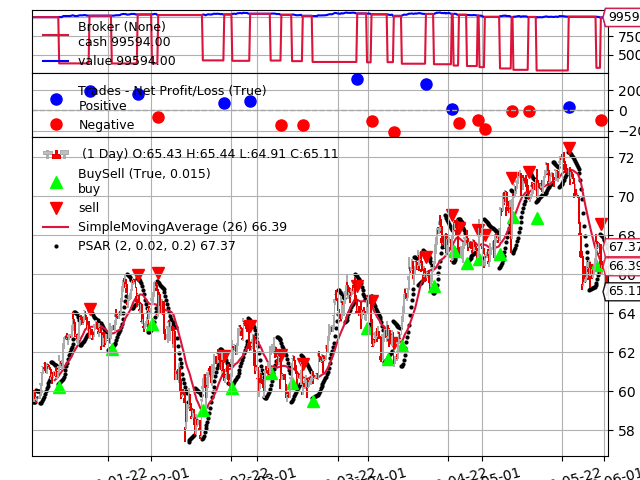

[[<Figure size 640x480 with 3 Axes>]]

In [4]:
# Create a cerebro entity
cerebro = bt.Cerebro(optreturn=False)

# Add a strategy
cerebro.addstrategy(TestStrategy, maperiod=26)
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe', timeframe=bt.TimeFrame.Months)

# Load data
folder_name = '5min'
fname_symbol = 'CL'
suffix = '5min_20160103_20190405'
# suffix = 'demo'

df = pd.read_parquet(os.path.join('../../data/processed/{}/'.format(folder_name), '{}_{}.parquet'.format(fname_symbol, suffix)))
df = (df.resample('4h', label='left', base=18).agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}))
df.columns = [col_name.lower() for col_name in df.columns]
df = df.dropna()

data = bt.feeds.PandasData(dataname = df['2017-01-01':'2018-01-01'])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(100000.0)

cerebro.addsizer(bt.sizers.FixedSize, stake=1000)

# We're trading futures, so we'll use the "commissions" to handle both slippage and commissions
slippage_and_comms = FixedSlippageAndCommisionScheme()
cerebro.broker.addcommissioninfo(slippage_and_comms)

# Alternatively, you can use:
# cerebro.broker.setcommission(commission=0.0)
# cerebro.broker.set_slippage_fixed(.00,  slip_open=True, slip_limit=True, slip_match=True, slip_out=TrueS)


# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
result = cerebro.run()
stats = result[0]
# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
print(f'In Sample Sharpe Ratio: {(stats.analyzers.mysharpe.get_analysis())[("sharperatio")]}')
# cerebro.plot(volume=False, iplot=True, style='candle')

## In-sample Optimization

In [5]:
# Create a cerebro entity
cerebro = bt.Cerebro(optreturn=False)

# Add a strategy
strats = cerebro.optstrategy(
    TestStrategy,
    maperiod=range(10, 31),
    af=numpy.arange(0.02,0.1, 0.02))

startcash = 100000

# Add the Data Feed to Cerebro
cerebro.adddata(data)
 
# Set our desired cash start
cerebro.broker.setcash(100000.0)

# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=1000)

# We're trading futures, so we'll use the "commissions" to handle both slippage and commissions
slippage_and_comms = FixedSlippageAndCommisionScheme()
cerebro.broker.addcommissioninfo(slippage_and_comms)

# Run over everything
starts = cerebro.run(maxcpus=1) 
 



In [6]:
st0 = [s[0] for s in starts]

periodcashvalues = [','.join([str(s.p.maperiod), str(s.p.af), str(s.thevalue)]) for s in st0]
print('ma,af,final value')
print('\n'.join(periodcashvalues))

ma,af,final value
10,0.02,104236.0
10,0.04,104236.0
10,0.06,104236.0
10,0.08,104236.0
11,0.02,102686.0
11,0.04,102686.0
11,0.06,102686.0
11,0.08,102686.0
12,0.02,103910.0
12,0.04,103910.0
12,0.06,103910.0
12,0.08,103910.0
13,0.02,103300.0
13,0.04,103300.0
13,0.06,103300.0
13,0.08,103300.0
14,0.02,104618.0
14,0.04,104618.0
14,0.06,104618.0
14,0.08,104618.0
15,0.02,103912.0
15,0.04,103912.0
15,0.06,103912.0
15,0.08,103912.0
16,0.02,105384.0
16,0.04,105384.0
16,0.06,105384.0
16,0.08,105384.0
17,0.02,106158.0
17,0.04,106158.0
17,0.06,106158.0
17,0.08,106158.0
18,0.02,106132.0
18,0.04,106132.0
18,0.06,106132.0
18,0.08,106132.0
19,0.02,106122.0
19,0.04,106122.0
19,0.06,106122.0
19,0.08,106122.0
20,0.02,104756.0
20,0.04,104756.0
20,0.06,104756.0
20,0.08,104756.0
21,0.02,103496.0
21,0.04,103496.0
21,0.06,103496.0
21,0.08,103496.0
22,0.02,104964.0
22,0.04,104964.0
22,0.06,104964.0
22,0.08,104964.0
23,0.02,106666.0
23,0.04,106666.0
23,0.06,106666.0
23,0.08,106666.0
24,0.02,106180.0
24,0.04,10618

## Out-of-Sample

In [7]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(TestStrategy, maperiod=26, af=2)
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe', timeframe=bt.TimeFrame.Months)


data = bt.feeds.PandasData(dataname = df['2018-01-01':'2018-06-01'])


# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(100000.0)
cerebro.addsizer(bt.sizers.FixedSize, stake=1000)
"""
For refference
class FixedSlippageAndCommisionScheme(bt.CommInfoBase):
    '''Use this for both slippage and commissions together'''
    params = (
        ('commission', 12),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED),
        )

    def _getcommission(self, size, price, pseudoexec):
        return self.p.commission
"""
# We're trading futures, so we'll use the "commissions" to handle both slippage and commissions
slippage_and_comms = FixedSlippageAndCommisionScheme()
cerebro.broker.addcommissioninfo(slippage_and_comms)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
result = cerebro.run()
stats = result[0]
# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
print(f'Out of Sample Sharpe Ratio: {(stats.analyzers.mysharpe.get_analysis())[("sharperatio")]}')
cerebro.plot(volume=False, iplot=True, style='candle')

Starting Portfolio Value: 100000.00
Final Portfolio Value: 99594.00
Out of Sample Sharpe Ratio: -0.06450945174710758


[[<Figure size 640x480 with 3 Axes>]]